Link to Grad Cam Images and Masks - https://drive.google.com/drive/folders/1loy6g4rRxXoZCmZCAtEGNnrwfWhrnM3r?usp=sharing

In [49]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50,ResNet50_Weights, resnet18, ResNet18_Weights
from torchvision.io import read_image, ImageReadMode
import torchvision
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import keras
import os
import shutil
import matplotlib.pyplot as plt

In [ ]:
# images = os.listdir("./imagenet-5-categories/test")
# for img in images:
#     str=""
#     for s in img:
#         if(s=='_'):
#             break
#         str = str + s
#     shutil.copyfile(f"./imagenet-5-categories/test/{img}",f"./imagenet-5-categories/{str}/{img}")
# print("Transferred all the Images to respective Folders")

Initializing Model and the target layers

In [51]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
target_layers = [model.layer4[-1]]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\hp/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.67MB/s]


In [4]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_size = (224, 224)
# array = get_img_array(img_path, size=img_size)

Taking a subset of Imagenet having 5 classes -> Airplane, Car, Cat, Dog, Elephant having 300 images each

In [4]:
# labels = {"airplane":[403,404,405],"cat":[281,282,283,284,285,286],"car":[751,817,829],"dog":[153,229,230,235,238,239,245,248,251,254,207,208],"elephant":[385,386]}

Get Maps , pass either single image or a batch of images

In [33]:
def Map(cam, input_tensor,image,label):

    targets = [ClassifierOutputTarget(label)]
    print(targets)
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)

    # You can also get the model outputs without having to re-inference
    model_outputs = cam.outputs

    return visualization, grayscale_cam

In [6]:
def preprocess(img_path):
    input_tensor = read_image(img_path,mode=ImageReadMode.RGB)
    input_tensor = input_tensor.float() # creating input tensor
    input_tensor.unsqueeze_(0)

    image = Image.open(img_path)
    image = np.array(image)
    image = image/255.

    return input_tensor,image

In [7]:
def apply_cam_on_dataset(cam,path,target,labels):
    img_path = os.listdir(path)
    for img in img_path:
        input_tensor,image = preprocess(path+"/"+img)
        visualization = Map(cam,input_tensor,target,image,labels)
        np.save(f"./imagenet-5-categories/grad_cam_{target}/{img}.npy",visualization)

In [ ]:
# Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layers)

# path_airplane = "./imagenet-5-categories/airplane"
# apply_cam_on_dataset(cam,path_airplane,"airplane",labels)

# path_elephant = "./imagenet-5-categories/elephant"
# apply_cam_on_dataset(cam,path_elephant,"elephant",labels)

# path_cat = "./imagenet-5-categories/cat"
# apply_cam_on_dataset(cam,path_cat,"cat",labels)

# path_car = "./imagenet-5-categories/car"
# apply_cam_on_dataset(cam,path_car,"car",labels)

# path_dog = "./imagenet-5-categories/dog"
# apply_cam_on_dataset(cam,path_dog,"dog",labels)


Define CAM object

In [52]:
cam = GradCAM(model=model, target_layers=target_layers)

Assigning Image Files to their labels

In [53]:
df_labels = pd.read_csv('val_rs.csv')
df_labels.reset_index(drop=True, inplace=True)
FileName = list(df_labels['filename'])
index = list(df_labels['label'])

labels = dict(map(lambda i,j : (i,j) , FileName,index))

Saving the Grad Cam Maps and Mask Matrices



In [ ]:
image_path = os.listdir("./val_rs-20240428T164525Z-001/val_rs")
for img in image_path:
    input_tensor, image = preprocess(f"./val_rs-20240428T164525Z-001/val_rs/{img}")
    visualization,output = Map(cam,input_tensor,image,labels[f"{img}"])
    output = output/255. #normalizing to create a mask, darker pixels depict the salient object
    plt.imshow(visualization)
    plt.savefig(f"./grad_cam_images/{img}")
    np.save(f"./grad_cam_masks_matrix/{img}",output)

Example

Grad Cam Image


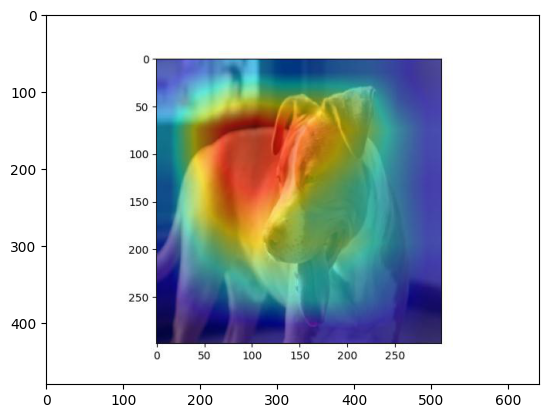

In [68]:
print("Grad Cam Image")
plt.imshow(Image.open("./grad_cam_images/ILSVRC2012_val_00008303.JPEG"))


Grad Cam Mask


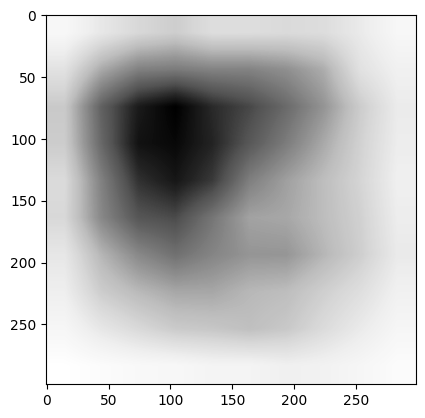

In [69]:
mask = np.load("./grad_cam_masks_matrix/ILSVRC2012_val_00008303.JPEG.npy")
print("Grad Cam Mask")
plt.imshow(mask,cmap="Greys")